In [1]:
# used for initializing the shapelets via KMeans
# NOTE: if you are just looking for a working solution of the learning shapelets algorithm you are advised to just use the implementation that is already provided by tslearn.
! pip install --user tslearn matplotlib

## Demo $\mathcal{L_R}$ loss

Demonstrates the use and effects of the regularized loss $\mathcal{L_R}$.

The data set used is the *UWaveGestureLibraryAll* dataset of the UCR archive:
> Yanping Chen, Eamonn Keogh, Bing Hu, Nurjahan Begum, Anthony Bagnall, Abdullah Mueen and Gustavo Batista (2015). The UCR Time Series Classification Archive. URL www.cs.ucr.edu/~eamonn/time_series_data/.

### NOTE I
The demo was performed on a GPU. You need to set `to_cuda=False` at the respective places in case you want to run on CPU. 

### NOTE II
To demonstrate the implementation, the shapelets to be learned are initialized via K-Means as was done in the original paper. To do so, we use the K-Means implementation of the library TSLearn. If you are just looking for a working implementation of LearningShapelets, you are advised to just use the TSLearn implementation. This repo just intends to provide an exemplary implementation using PyTorch.

In [1]:
import os
## TODO change to 0
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

In [2]:
import random
import numpy
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

In [3]:
from src.learning_shapelets import LearningShapelets

### Load and Normalze Data

Helper functions to normalize the data:

In [19]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

Load and normalize training data:

In [20]:
dataset = "UWaveGestureLibraryAll"
# Load training data
X_train = numpy.load(open(os.path.join('data', f'{dataset}_train.npy'), 'rb'))
X_train_size = X_train.shape[0]
print(f"Shape X_train: {X_train.shape}")
# load trainng data labels
y_train = numpy.load(open(os.path.join('data', f'{dataset}_train_labels.npy'), 'rb'))
# normalize training data
X_train, scaler = normalize_data(X_train)

Shape X_train: (896, 1, 945)


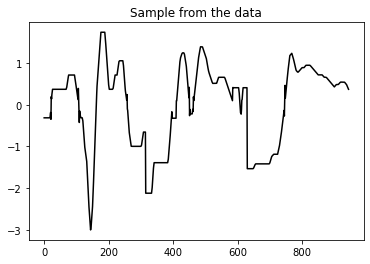

In [6]:
pyplot.title("Sample from the data")
pyplot.plot(X_train[0, 0], color='black')

### Learning Shapelets

Train a model using *Learning Shapelets* with cross-entropy loss as proposed in the orginial paper.

In [7]:
def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

In [8]:
def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

Initialize parameters:

In [9]:
n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 48 shapelets
shapelets_size_and_len = {189: 16, 378: 16, 567: 16}
dist_measure = "euclidean"
lr = 4e-3
wd = 1e-4
epsilon = 1e-7
batch_size = 256
shuffle = True
drop_last = False

Initialize shapelets via k-Means:

In [140]:
shapelets_blocks = []
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    shapelets_blocks.append(weights_block)

Initialize *Learning Shapelets* model:

In [141]:
learning_shapelets = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure)

Set weights:

In [142]:
for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets.set_shapelet_weights_of_block(i, shapelets_block)

Initialize optimizer for the *Learning Shapelets* model:

In [143]:
optimizer = optim.Adam(learning_shapelets.model.parameters(), lr=lr, weight_decay=wd, eps=epsilon)
learning_shapelets.set_optimizer(optimizer)

#### Train Learning Shapelets Model

In [133]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    return (predictions == Y).sum() / Y.size

In [128]:
epochs = 300
n_epoch_steps = 5 * 2

In [48]:
losses = []
train_acc_last = 0
for _ in range(n_epoch_steps):
    losses += learning_shapelets.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    train_acc_current = eval_accuracy(learning_shapelets, X_train, y_train)
    if train_acc_current - train_acc_last < 1e-3 or train_acc_current == 1.0:
        break
    train_acc_last = train_acc_current

Loss: 1.2535823583602905:   6%|███████▍                                                                                                                    | 12/200 [00:40<10:37,  3.39s/it]


KeyboardInterrupt: 

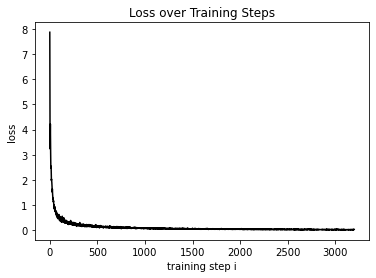

In [20]:
pyplot.plot(losses, color='black')
pyplot.title("Loss over Training Steps")
pyplot.xlabel("training step i")
pyplot.ylabel("loss")
pyplot.show()

#### Evaluate Accuracy of Learning Shapelets Model

Load test data:

In [21]:
# Load data set
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)

Shape X_train: (3582, 1, 945)


In [22]:
test_acc = eval_accuracy(learning_shapelets, X_test, y_test)

Accuracy: 0.911501954215522


### Learning Shapelets with $\mathcal{L_R}$ loss

Train a model using *Learning Shapelets* with $\mathcal{L_R}$ loss as proposed here.

Initialize additional parameters:

In [146]:
l1 = 0.1
l2 = 0.01
k = int(0.1 * batch_size) if batch_size <= X_train_size else X_train_size

Initialize model:

In [147]:
learning_shapelets_Lr = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure,
                                       l1=l1,
                                       l2=l2,
                                       k=k)

Set weights:

In [148]:
for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets_Lr.set_shapelet_weights_of_block(i, shapelets_block)

Initialize optimizer for the *Learning Shapelets* model:

In [149]:
optimizer = optim.Adam(learning_shapelets_Lr.model.parameters(), lr=lr, eps=epsilon)
learning_shapelets_Lr.set_optimizer(optimizer)

#### Train Model with $\mathcal{L_R}$

In [124]:
n_epoch_steps = 1
print(n_epoch_steps)
shapelets_size_and_len = {567: 16}

1


In [150]:
print(shapelets_size_and_len)
epochs=200

{567: 16}


In [151]:
losses_acc = []
losses_dist = []
losses_sim = []
train_acc_last_Lr = 0
for _ in range(n_epoch_steps):
    losses_acc_i, losses_dist_i, losses_sim_i = \
        learning_shapelets_Lr.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=drop_last)
    losses_acc += losses_acc_i
    losses_dist += losses_dist_i
    losses_sim += losses_sim_i
    train_acc_current_Lr = eval_accuracy(learning_shapelets_Lr, X_train, y_train)
    if train_acc_current_Lr - train_acc_last_Lr < 1e-3 or train_acc_current_Lr == 1.0:
        break
    train_acc_last_Lr = train_acc_current_Lr

Loss CE: 0.14304731786251068, Loss dist: 1.326067328453064, Loss sim: 0.00017490227764938027: 100%|█| 200/200 [07:59<00
  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.9441964285714286


Loss CE: 0.14628718793392181, Loss dist: 1.3137352466583252, Loss sim: 0.00017585797468200326:   4%| | 9/200 [00:22<08:


KeyboardInterrupt: 

In [152]:
learning_shapelets_Lr

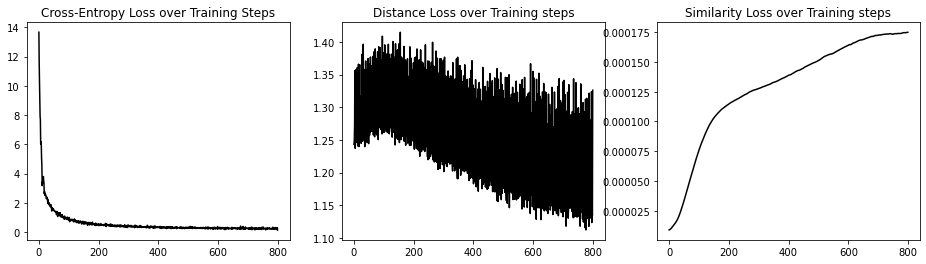

In [153]:
fig, axes = pyplot.subplots(1, 3)
fig.set_size_inches(16, 4)

axes[0].plot(losses_acc, color='black')
axes[0].title.set_text("Cross-Entropy Loss over Training Steps")

axes[1].plot(losses_dist, color='black')
axes[1].title.set_text("Distance Loss over Training steps")

axes[2].plot(losses_sim, color='black')
axes[2].title.set_text("Similarity Loss over Training steps")

pyplot.show()

### Evaluate Accuracy of Learning Shapelets Model with $\mathcal{L_R}$

In [154]:
test_acc_Lr = eval_accuracy(learning_shapelets_Lr, X_test, y_test)

Accuracy: 0.8944723618090452


## Compare the Shapelets of the two Models

Define some helper functions:

In [ ]:
def filterNanFromShapelet(shapelet):
    """
    Filter NaN values from a shapelet.
    Needed for the output of learning shapelets from tslearn, since smaller size shapelets are padded with NaN values.
    Note: Make sure the NaN values are only leading or trailing.
    """
    return shapelet[~numpy.isnan(shapelet)]

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, filterNanFromShapelet(shapelet)])
    return padded_shapelet

def torch_dist_ts_shapelet(ts, shapelet, to_cuda=True):
    """
    Use PyTorch to calculate the distance between a shapelet and a time series.
    Implemented via unfolding.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if to_cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    if shapelet.dim() == 1:
        shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[1], 1)
    # calculate euclidean distance over each segment
    dists = torch.sum(torch.cdist(ts, shapelet, p=2), dim=0)
    # filter min dist
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def dists_to_shapelet(data, shapelet, to_cuda=True):
    """
    Calculate the distances of a shapelet to a bunch of time series.
    """
    shapelet = filterNanFromShapelet(shapelet)
    dists = []
    for i in range(len(data)):
        dists.append((torch_dist_ts_shapelet(data[i,:], shapelet, to_cuda=to_cuda), i))
    return sorted(dists, key=lambda x: x[0][0])



def plot_shapelet_on_ts_at_i(shapelet, ts, i, title="", axis=None):
    """
    Plot a shapelet on top of a timeseries
    """
    shapelet = filterNanFromShapelet(shapelet)
    padded_shapelet = lead_pad_shapelet(shapelet, i)
    if axis is None:
        pyplot.clf()
        pyplot.rcParams["figure.figsize"] = (23, 6)
        pyplot.plot(ts)
        pyplot.plot(padded_shapelet)
    else:
        axis.plot(ts)
        axis.plot(padded_shapelet)
        
#CUSTOM:

def dists_ts_to_shapelets(ts, shapelets, to_cuda=False):
    """
    Calculate the distances of shapelets to a timeseries
    """
    dists = []
    for i in range(len(shapelets)):
        shapelet = filterNanFromShapelet(shapelets[i])
        dists.append((torch_dist_ts_shapelet(ts, shapelet, to_cuda=to_cuda),i))
    return sorted(dists, key=lambda x: x[0][0])

def plot_ts_and_shapelet(ts,shapelet): 
    sh = filterNanFromShapelet(shapelet)
    dist, pos = torch_dist_ts_shapelet(ts,sh,to_cuda=False)
    padded_shapelet = lead_pad_shapelet(sh,pos)
    pyplot.plot(ts.flatten())
    pyplot.plot(padded_shapelet)
    pyplot.show()


In [157]:
shapelets_Lr_npsave = learning_shapelets_Lr.get_shapelets()
print(len(shapelets_Lr_npsave))

np.save('shapelets_Lr_16.npy', shapelets_Lr_npsave)

16


In [52]:
shapelets_ce = learning_shapelets.get_shapelets()
shapelets_Lr = learning_shapelets_Lr.get_shapelets()
n_shapelets_ce = shapelets_ce.shape[0]
n_shapelets_Lr = shapelets_Lr.shape[0]
n_shapelets = max(n_shapelets_ce, n_shapelets_Lr)

NameError: name 'learning_shapelets' is not defined

## With saved shapelets

In [158]:
shapelets_ce = numpy.load("shapelets_ce.npy")
shapelets_Lr = numpy.load("shapelets_Lr_16.npy")
n_shapelets_ce = shapelets_ce.shape[0]
n_shapelets_Lr = shapelets_Lr.shape[0]
n_shapelets = max(n_shapelets_ce, n_shapelets_Lr)

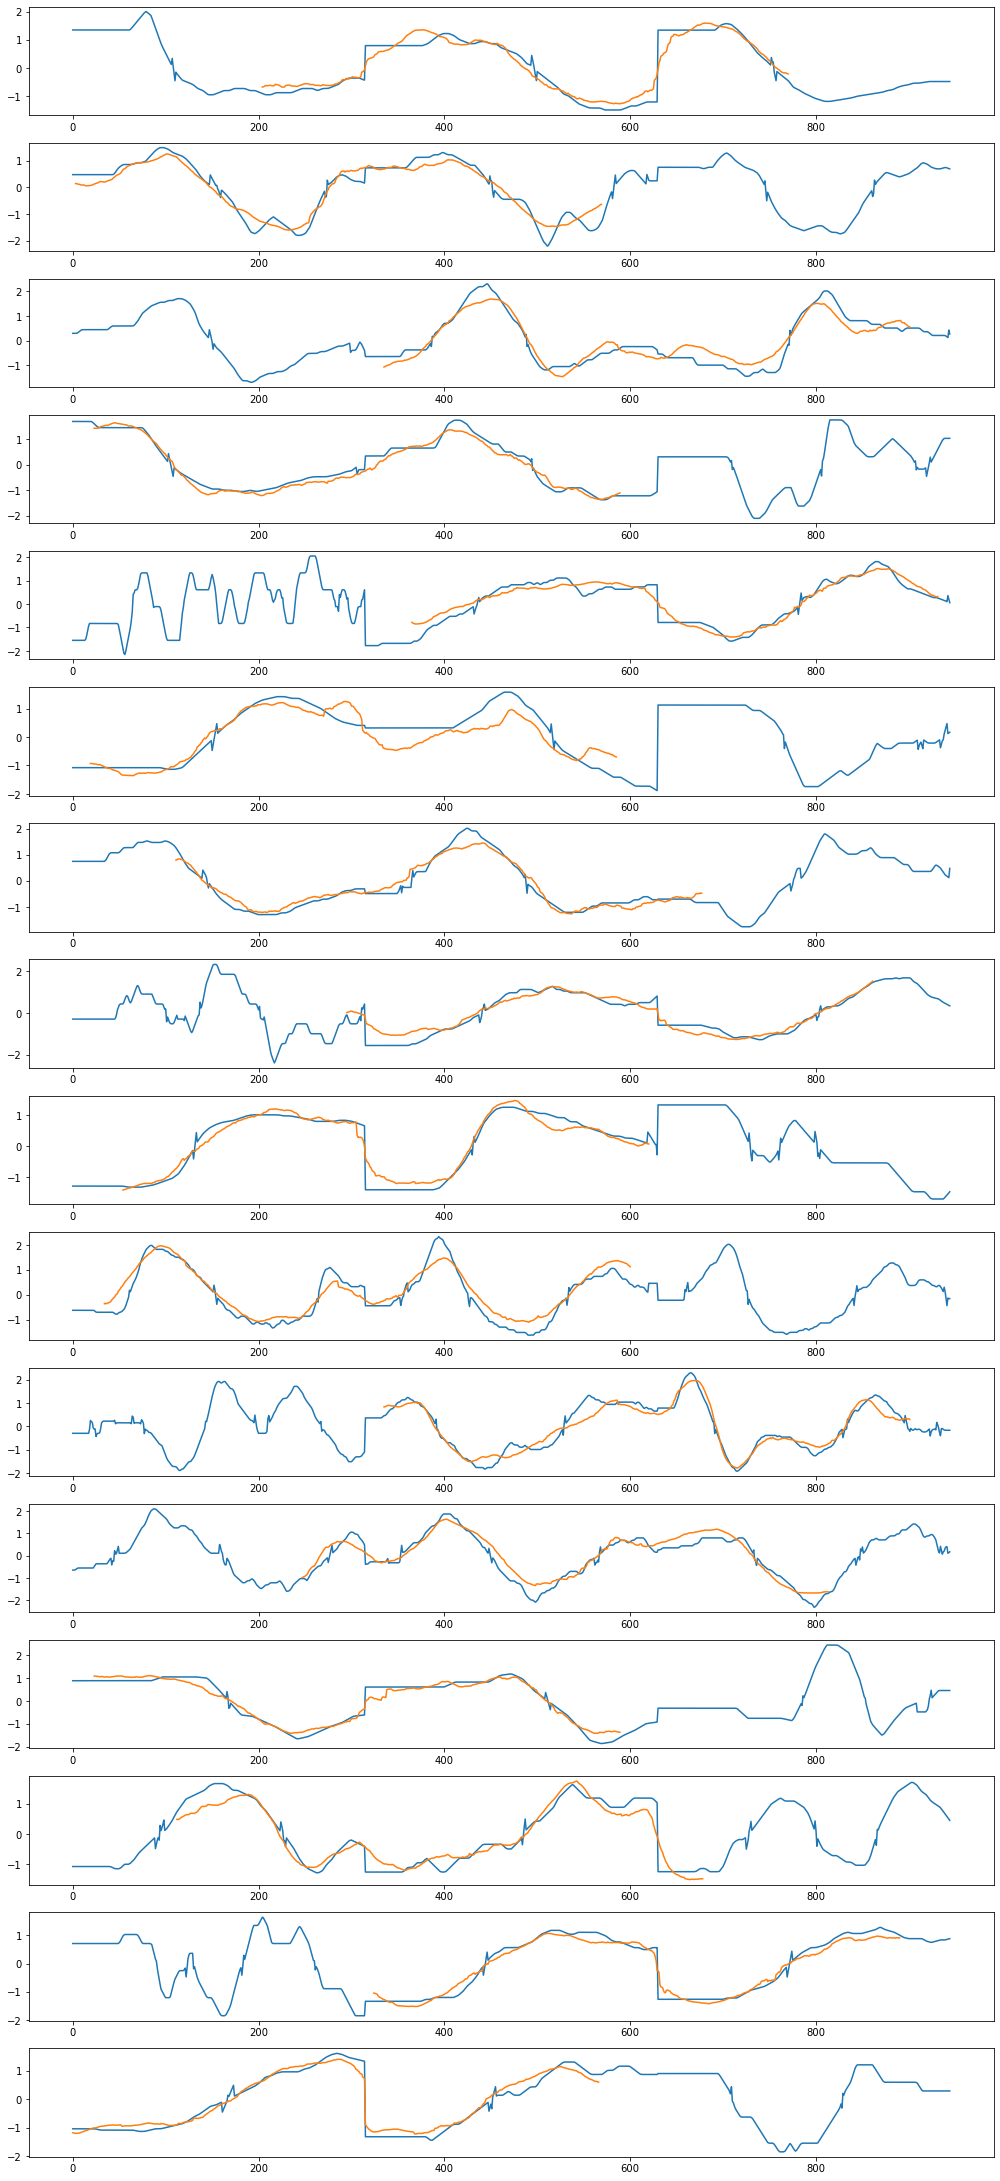

In [159]:
fig, axes = pyplot.subplots(n_shapelets, 1)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
#fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

relative_distances_gra = []
relative_distances_contrastive = []
for i in range(n_shapelets):
    if i < n_shapelets_Lr:
        shapelet_Lr = filterNanFromShapelet(shapelets_Lr[i, 0])
        best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=False)[0]
        plot_shapelet_on_ts_at_i(shapelet_Lr, X_test[best_match_Lr[1], 0], best_match_Lr[0][1], axis=axes[i])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()

In [24]:
best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=False)

In [25]:
best_match_Lr[:10]

[((5.338199138641357, 63), 2290),
 ((5.75212287902832, 32), 3437),
 ((5.852997779846191, 41), 1408),
 ((6.4082136154174805, 25), 3418),
 ((6.463325023651123, 32), 1761),
 ((6.550736904144287, 55), 843),
 ((6.557949542999268, 29), 2847),
 ((6.5743021965026855, 32), 1163),
 ((6.8691205978393555, 37), 2346),
 ((6.895723819732666, 48), 836)]

### Find best timeseries for specific shapelet

[2, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3] {2, 3, 4}


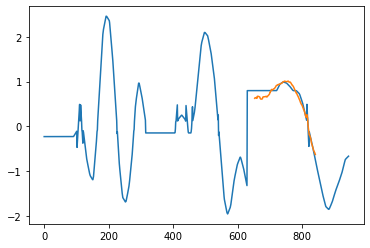

In [26]:
shapelet_Lr = shapelets_Lr[10, 0]
best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=False)
#print(best_match_Lr[:10])
#X_test[best_match_Lr[0][1]]
s = []
w = []
n = []
for i in range(len(best_match_Lr)):
    s.append(y_test[best_match_Lr[i][0][1]])
    w.append(y_test[best_match_Lr[i][1]])
    n.append(best_match_Lr[i][1])
#print(s[:50],set(s[:50]))
#same classification
print(w[:50],set(w[:50]))

ii = 1
#print(numpy.array(best_match_Lr)[0,1])
#print(best_match_Lr[0][0][1],shapelet_Lr)

#print(shapelet_Lr)
shapelet1 = filterNanFromShapelet(shapelet_Lr)
padded_shapelet = lead_pad_shapelet(shapelet1,best_match_Lr[ii][0][1])
pyplot.plot(X_test[n[ii]].flatten())
pyplot.plot(padded_shapelet)


In [228]:
best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=False)

PRED 0
((5.0343217849731445, 41), 12) ((6.3182573318481445, 458), 8) ((6.403377056121826, 47), 7)


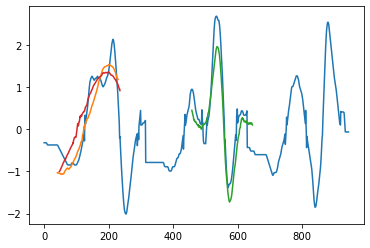

In [501]:
ts = 1984

closest_explanations = dists_ts_to_shapelets(X_test[ts],shapelets_Lr)
#print(closest_explanations)

sh0 = closest_explanations[0]
sh1 = closest_explanations[1]
sh2 = closest_explanations[2]
#################################
#Closest Shapelets for timeseries
shp0 = shapelets_Lr[sh0[1]]
shapelet0 = filterNanFromShapelet(shp0)
#Second & third closest shapelet
shp1 = shapelets_Lr[sh1[1]]
shapelet1 = filterNanFromShapelet(shp1)
###
shp2 = shapelets_Lr[sh2[1]]
shapelet2 = filterNanFromShapelet(shp2)
#Visualize
padded_shapelet0 = lead_pad_shapelet(shapelet0,sh0[0][1])
padded_shapelet1 = lead_pad_shapelet(shapelet1,sh1[0][1])
padded_shapelet2 = lead_pad_shapelet(shapelet2,sh2[0][1])
pyplot.plot(X_test[ts].flatten())
pyplot.plot(padded_shapelet0)
pyplot.plot(padded_shapelet1)
pyplot.plot(padded_shapelet2)
print("PRED",y_test[ts])
print(sh0,sh1,sh2)

### Find best shapelets defining a class

In [27]:
import numpy as np

def find_ts_per_class(y_test, searched_class): 
    normal_sort = np.sort(y_test)
    arg_sort = np.argsort(y_test)
    class_x = arg_sort[np.where(normal_sort==searched_class)]
    return class_x
print(find_ts_per_class(y_test, 0))

[1984 3246 2929  394 2516 2928 3251 3256 1323 2521 1684 3260 3262  797
  380  379 2228 2219  373 1695 3273 2527 1699 1700  365 3278 3279 1705
 2931  783  400  402 2484  758 1642  759  762  429 1645  426 1335 1648
 2247 1652  768  809 1654  417 2239  770 1663 2235 2234 2939 2513 2933
 2932 2233  781 1673 2243 1708 1709 2536 2883 1753  855 3337 1756 3340
  862 2166 1762 3344  284 2562 2870 2884  278 2866  878 1257 2157  269
  268  266 1777  263  883 3363 1255 3365  276  441  305 2362 1711 2538
  352 2913 3287  347 2909 1300 3290 1720 3293 2202  337  306  829 3305
 3306  840 3316 1740 2893 2186 3324 2554  847 3326  312 2885  830 2564
  443 2475 2386 3099  566  564 3025 2332 2390 1533  557 3111 1442  665
 1441  551 2396 3122 1092  676 1553 3128 3129 2407 1559 1423  533 1422
 3007 3028 2342  574 2343 3058  612 1487 3052 1490  623 2366 3065  630
 3048 1501  598 1474 2416 3076 1473 3077  591  588  638 3081 2350 3045
  640 2377 2379 2384 1455  633 2421 1567 1411 2453 2457  476  475 1375
  472 

In [28]:
dist_set = []
class_0 = find_ts_per_class(y_test,0)
for ts in class_0: 
    closest_explanations = dists_ts_to_shapelets(X_test[ts],shapelets_Lr)
    #print(closest_explanations)
    sh0 = closest_explanations[0]
    sh1 = closest_explanations[1]
    sh2 = closest_explanations[2]
    dist_set.append((sh0[1],sh1[1],sh2[1]))
    """
    #################################
    #Closest Shapelets for timeseries
    shp0 = shapelets_Lr[sh0[1]]
    shapelet0 = filterNanFromShapelet(shp0)
    #Second & third closest shapelet
    shp1 = shapelets_Lr[sh1[1]]
    shapelet1 = filterNanFromShapelet(shp1)
    ###
    shp2 = shapelets_Lr[sh2[1]]
    shapelet2 = filterNanFromShapelet(shp2)
    #Visualize
    padded_shapelet0 = lead_pad_shapelet(shapelet0,sh0[0][1])
    padded_shapelet1 = lead_pad_shapelet(shapelet1,sh1[0][1])
    padded_shapelet2 = lead_pad_shapelet(shapelet2,sh2[0][1])
    pyplot.plot(X_test[ts].flatten())
    pyplot.plot(padded_shapelet0)
    pyplot.plot(padded_shapelet1)
    pyplot.plot(padded_shapelet2)
    print("PRED",y_test[ts])
    break
    """


#print(dist_set)

In [29]:
print(len(set(dist_set)))

260


In [41]:
#Deprecated
#Count most frequent explanation used
import collections
explanations = dict()
for x in set(dist_set):
    explanations[x] = dist_set.count(x)
    
#def sort_by_relevance()
from collections import Counter
most_com_exp_per_class = dict()
for i in best_exp.keys():
    counted = Counter([x[1] for x in best_exp[i]])
    cnt = counted.most_common(10)
    most_com_exp_per_class[i] = cnt
mc_exp = []
for e in most_com_exp_per_class:
    mc_exp.append(tuple([x[0] for x in most_com_exp_per_class[e]]))
    
print(mc_exp)
    
sort_by_value = dict(sorted(explanations.items(), key=lambda item: item[1], reverse=True))

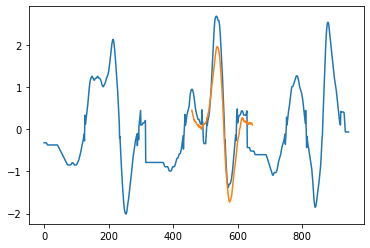

In [39]:
plot_ts_and_shapelet(X_test[1984],shapelets_Lr[8]) 


In [166]:
%%time
def get_best_explanations_per_class(number,y):
    normal_sort = np.sort(y)
    arg_sort = np.argsort(y)
    #For each class
    explanations_per_class = dict()
    for i in set(y):
        explanations_per_class[i] = list()
        ts_per_class = arg_sort[np.where(normal_sort==i)]
        for ts in ts_per_class: 
            explanations = dists_ts_to_shapelets(X_test[ts],shapelets_Lr)[:number]
            explanations_per_class[i].append(*explanations) #[for single values *explnations]
    return explanations_per_class

best_exp = get_best_explanations_per_class(1,y_test)


Wall time: 25.2 s


{0: [((17.022777557373047, 145), 3),
  ((17.392810821533203, 100), 2),
  ((11.954217910766602, 185), 3),
  ((9.965551376342773, 115), 13),
  ((13.101155281066895, 378), 2),
  ((10.223213195800781, 181), 3),
  ((9.654400825500488, 110), 13),
  ((19.578096389770508, 331), 8),
  ((10.769638061523438, 41), 2),
  ((8.80197811126709, 167), 3),
  ((11.841375350952148, 115), 13),
  ((10.340893745422363, 64), 2),
  ((17.49943733215332, 32), 9),
  ((10.516283988952637, 117), 13),
  ((11.290698051452637, 111), 13),
  ((16.744525909423828, 144), 3),
  ((16.109872817993164, 124), 13),
  ((15.079670906066895, 97), 13),
  ((10.9730806350708, 116), 13),
  ((10.339546203613281, 315), 15),
  ((13.008021354675293, 159), 3),
  ((13.415271759033203, 41), 2),
  ((13.968358993530273, 114), 13),
  ((11.237518310546875, 164), 3),
  ((11.156262397766113, 149), 3),
  ((16.41815757751465, 139), 3),
  ((15.762628555297852, 48), 2),
  ((12.227726936340332, 339), 8),
  ((12.397193908691406, 47), 2),
  ((12.565886497

In [108]:
#print(best_exp[0])
def extract_tuple(best_exp, ex): 
    s = []
    for e in best_exp[ex]: 
        #print(e)
        s.append((e[0][1],e[1][1]))#,e[2][1]))
    return s

e0 = extract_tuple(best_exp,0)
e1 = extract_tuple(best_exp,1)

print(len(set(e0)), len(set(e1)), set(e0).intersection(set(e1)))
intersec = set(e0).intersection(set(e1))

print(len(e0),len(e0)+len(e1))

count = 0

for ss in intersec: 
     count += e0.count(ss) + e1.count(ss)

print(len(e0)+len(e1), count, len(e0)+len(e1)-count, (889-367)/889)

106 82 {(12, 1), (12, 7), (3, 1), (8, 3), (9, 14), (11, 14), (1, 12), (15, 11), (7, 1), (1, 15), (6, 11), (7, 10), (3, 9), (8, 5), (11, 7), (1, 5), (1, 11), (11, 13), (1, 8), (15, 7), (15, 1), (7, 12), (7, 15), (12, 11), (12, 8), (15, 12), (10, 4), (9, 6), (11, 6), (11, 12), (11, 15), (7, 11)}
437 889
889 367 522 0.5871766029246345


In [31]:
#def sort_by_relevance()
from collections import Counter
most_com_exp_per_class = dict()
for i in best_exp.keys():
    counted = Counter([x[1] for x in best_exp[i]])
    cnt = counted.most_common(10)
    most_com_exp_per_class[i] = cnt
mc_exp = []
for e in most_com_exp_per_class:
    mc_exp.append(tuple([x[0] for x in most_com_exp_per_class[e]]))
    
print(mc_exp)

[(1, 7, 12, 6, 11, 3, 4, 2, 9, 10), (8, 11, 15, 12, 7, 1, 6, 9, 0, 5), (1, 6, 11, 7, 12, 15, 3, 9, 10, 4), (4, 9, 14, 10, 6, 0, 3, 7, 1, 11), (14, 9, 4, 10, 3, 0, 6, 7, 13, 12), (11, 6, 1, 9, 12, 15, 7, 10, 14, 3), (5, 15, 0, 13, 1, 9, 3, 2, 12, 11), (0, 13, 5, 15, 3, 9, 10, 14, 6, 1)]


In [170]:
def find_most_frequent_shapelets(best_explnations, y_class, top_n): 
    gpd =pd.DataFrame(best_explnations[y_class],columns=["Dist_Pos","Shapelet"]).groupby(["Shapelet"])
    most_frequent = gpd.describe().sort_values(('Dist_Pos',  'count'), ascending=False)[:top_n]
    return most_frequent


find_most_frequent_shapelets(best_exp,2,2) 

Dist_Pos                                      
            count unique                       top freq
Shapelet                                               
15            140    140    (7.370395183563232, 0)    1
8              98     98  (12.041905403137207, 54)    1

In [162]:
%%time
def plot_class_and_shapelets(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
        
    for sp in shp.iterrows(): 

        shp_n = sp[0]
        shp_n = shapelets_Lr[shp_n]
        shp_n = filterNanFromShapelet(shp_n)
        
        shp_pos_n = sp[1][2][1]
        
        shp_freq = sp[1][1]
        shp_avg_class_dist = sp[1][2][0] 
        
        padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
        pyplot.plot(padded_shapelet, label=f"shp_n: {sp[0]} Frequency: {shp_freq} | Avg Dist: {shp_avg_class_dist}", linewidth=3)
        plt.legend(loc="upper left")
    pyplot.show()


    
"""
yclass_n = 0
exp_per_ts = 1
best_exp = get_best_explanations_per_class(exp_per_ts,y_test)
most_frq = find_most_frequent_shapelets(best_exp,yclass_n,5) 
cl = find_ts_per_class(y_test,yclass_n)
plot_class_and_shapelets(0, cl, X_test,most_frequent)
"""



Wall time: 0 ns


'\nyclass_n = 0\nexp_per_ts = 1\nbest_exp = get_best_explanations_per_class(exp_per_ts,y_test)\nmost_frq = find_most_frequent_shapelets(best_exp,yclass_n,5) \ncl = find_ts_per_class(y_test,yclass_n)\nplot_class_and_shapelets(0, cl, X_test,most_frequent)\n'

In [54]:
best_exp[0][0]

((5.0343217849731445, 41), 12)

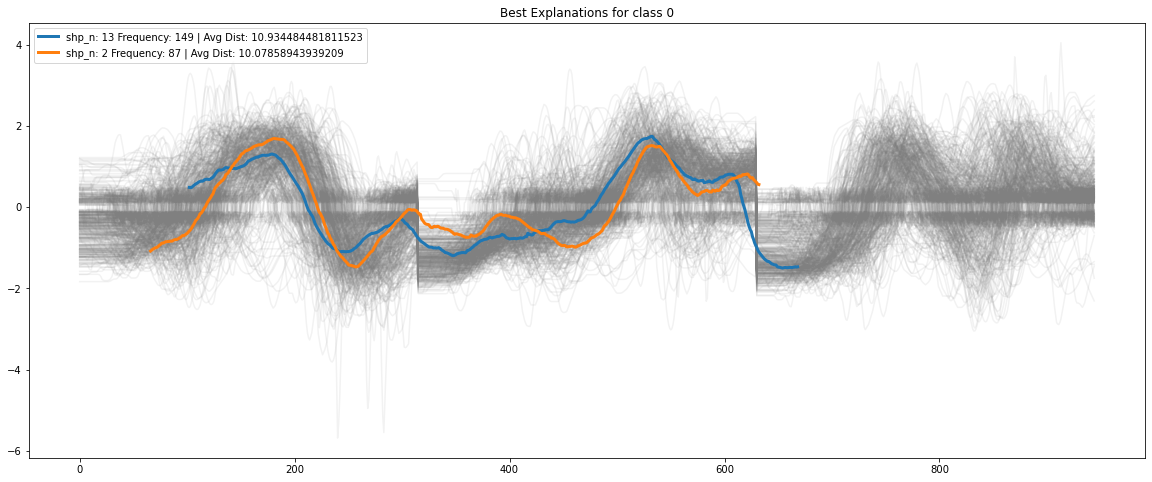

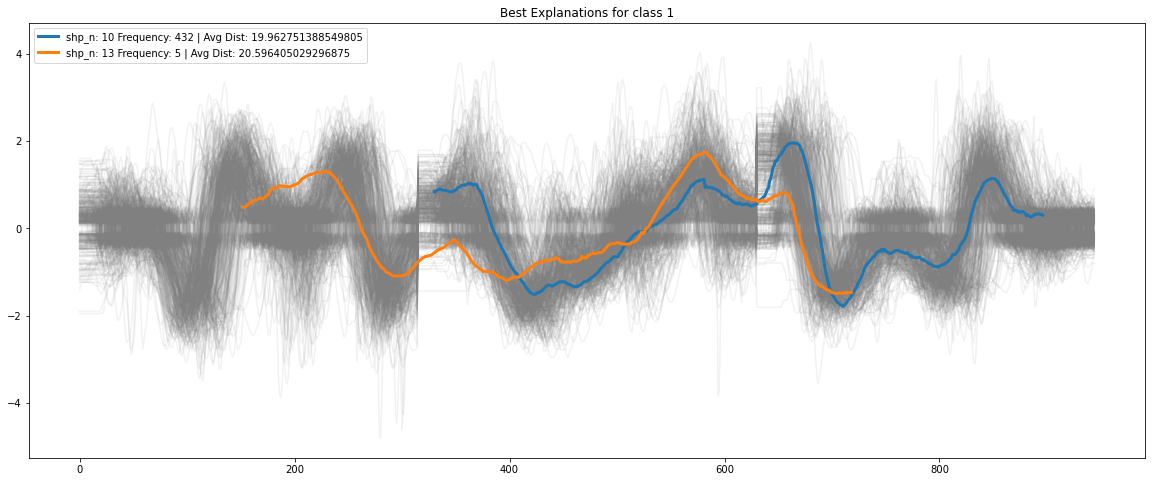

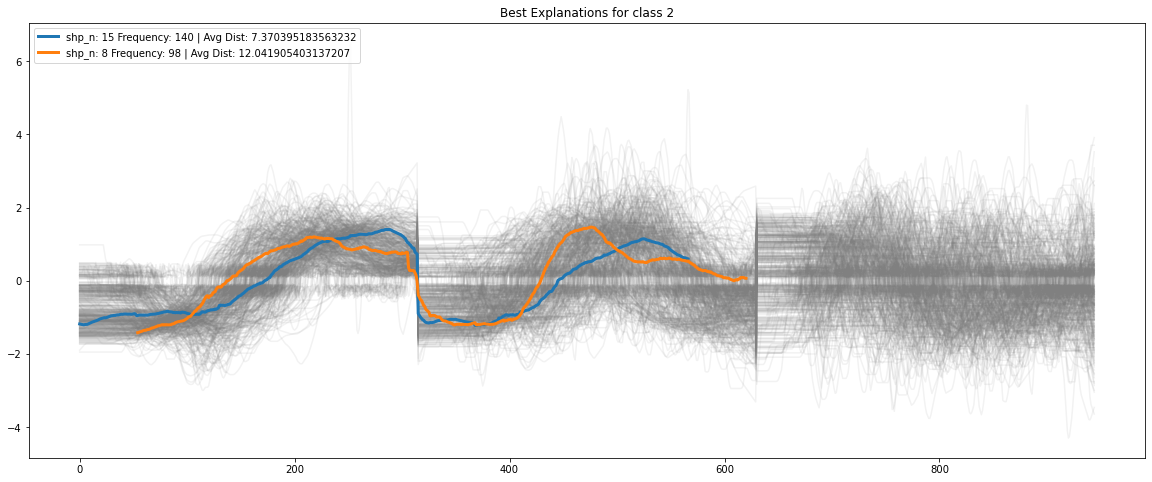

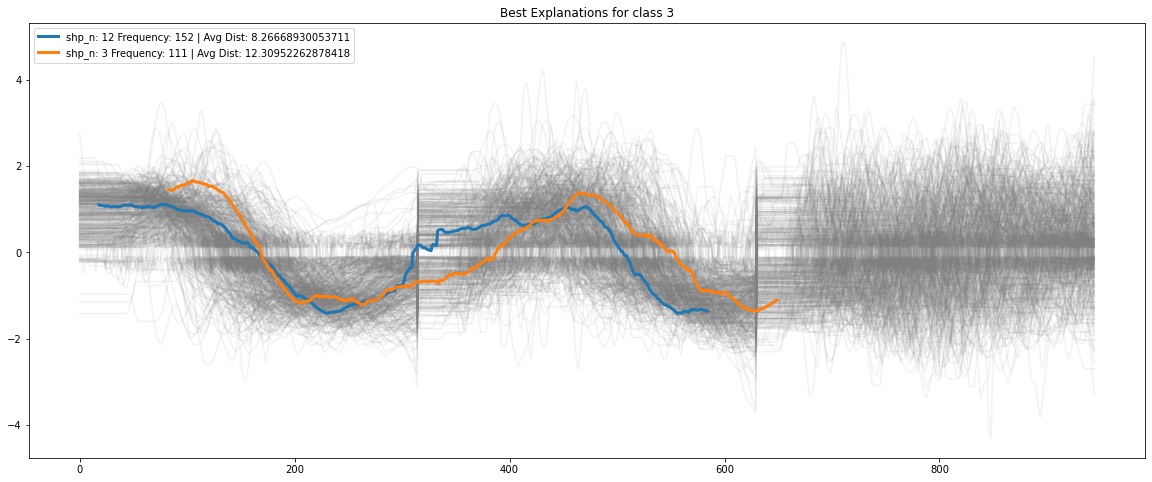

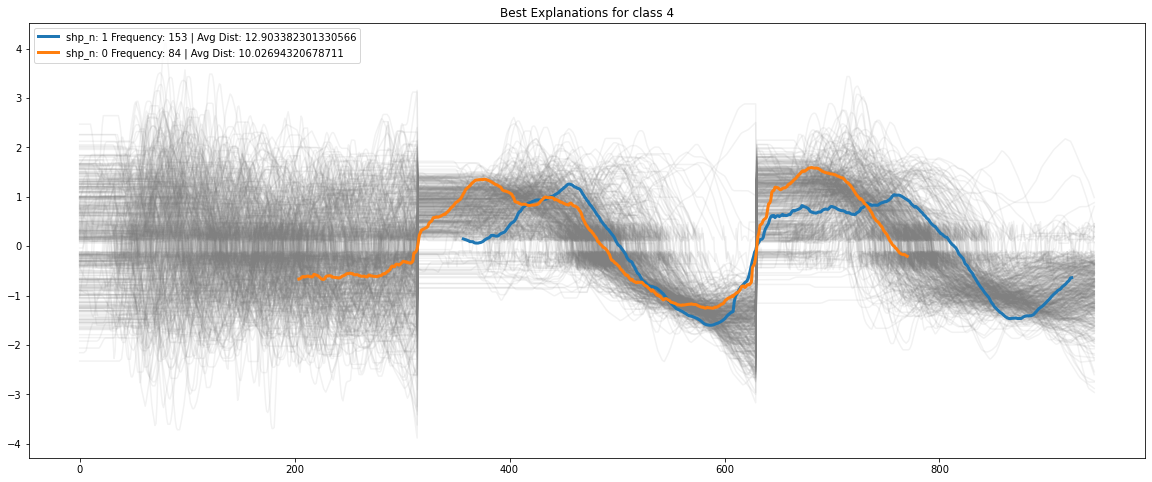

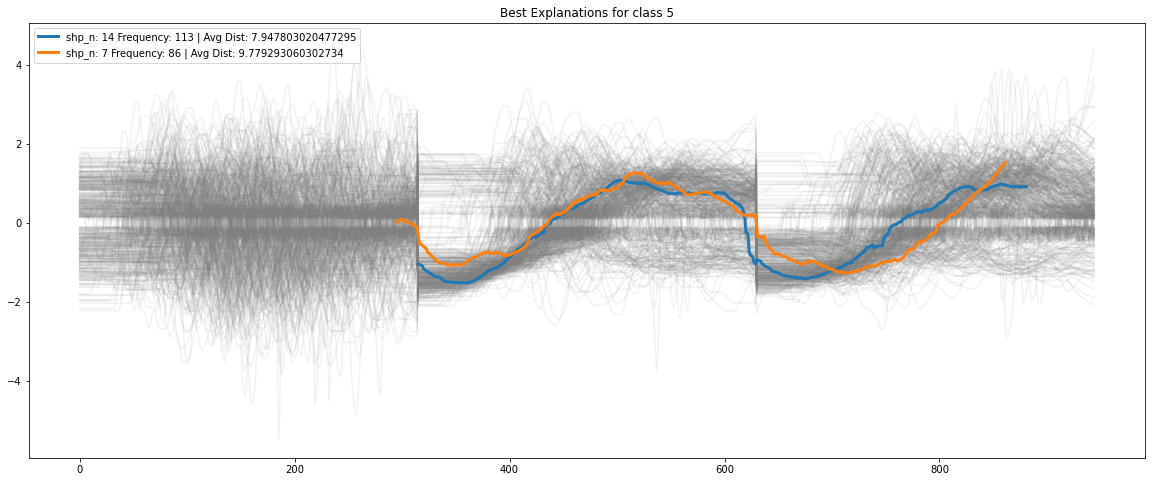

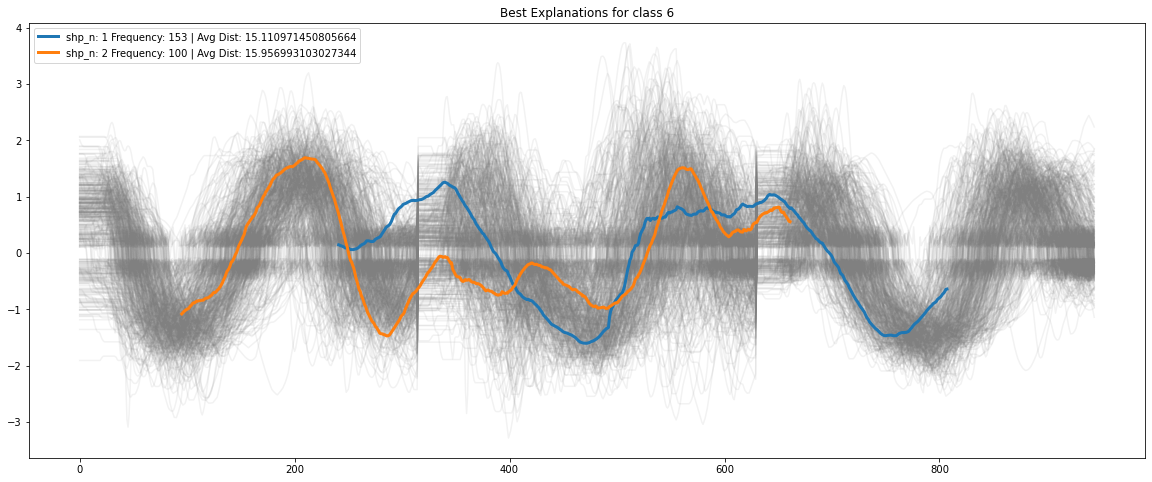

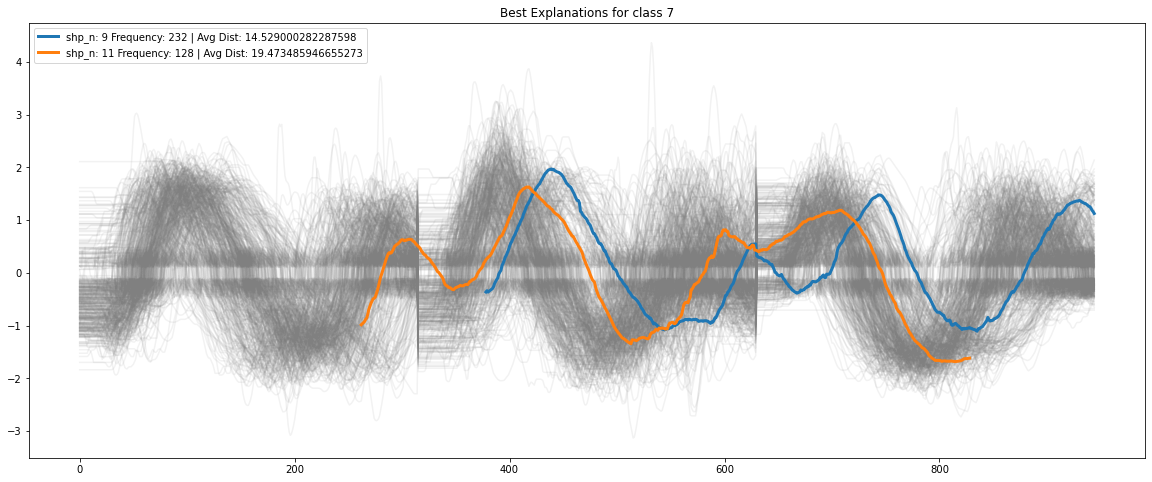

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

yclass_n = 2
exp_per_ts = 1
def plot_shapelets_for_classes(best_exp,n_exp,yclasses):
    for yclass_n in yclasses: 
        most_frq = find_most_frequent_shapelets(best_exp,yclass_n,n_exp) 
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets(yclass_n, cl, X_test,most_frq)
    

plot_shapelets_for_classes(best_exp,2, set(y_test))


In [52]:
print(len(best_exp[0]))
print(len(find_ts_per_class(y_test, 0)))

437
437
